# Latent space zeroing

This notebook investigates the impact of zeroing-out embeddings or part of the embeddings on the prediction error.

# imports

In [1]:


import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import torch
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from MGraphDTA.regression.preprocessing import GNNDatasetFull, GNNDataset
from xai_dta.utils.models import load_model, load_untrained_model
from xai_dta.config import PROJ_ROOT

get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")


from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

from src.utils.plot_utils import set_plot_style, get_styled_figure_ax, style_legend, adjust_plot_limits
DATASET_COLORS = DATASET_COLORS = ['#95BB63', '#7E7EA5', '#487C7D', '#EA805D', '#4897DC']

2025-11-26 13:18:52.650 | INFO     | xai_dta.config:<module>:17 - PROJ_ROOT path is: /home/alex/dev/projects/dl_imt4392/dl_project


In [2]:


device='cpu'
dataset_name='kiba'
split='test'

root = os.path.abspath(os.path.join(os.getcwd(), '..'))
model_trained = load_model(
    PROJ_ROOT, 
    model_name='kiba/epoch-2578, loss-0.0122, cindex-0.9741, test_loss-0.1265.pt'
)
dataset_path = os.path.join(PROJ_ROOT, "MGraphDTA", "regression", "data", dataset_name)
dataset = GNNDataset(
    root = dataset_path,
    train=split=='train',
    transform_unique=True
)
max_sample_train = len(dataset)
data_raw = pd.read_csv(os.path.join(dataset_path, 'raw', f"data_{split}.csv"))

2025-11-26 13:18:53.566 | INFO     | MGraphDTA.regression.preprocessing:load_graph_dict:291 - Loading graph dict from /home/alex/dev/projects/dl_imt4392/dl_project/MGraphDTA/regression/data/kiba/processed/graph_dict.pt
2025-11-26 13:18:53.931 | INFO     | MGraphDTA.regression.preprocessing:__init__:54 - Graph dict with 2068 entries loaded.


In [3]:


filename = f'embeddings_train_kiba_{max_sample_train}_2578.npy'
filenamelabel = f'labels_train_kiba_{max_sample_train}_2578.npy'
filenameindices = f'indices_train_kiba_{max_sample_train}_2578.npy'
folder = 'results/latent_space'
embeddings = np.load(os.path.join(folder, filename))
labels = np.load(os.path.join(folder, filenamelabel))
indices = np.load(os.path.join(folder, filenameindices))
print(f"Loaded {embeddings.shape} embeddings; {labels.shape} labels")

Loaded (19709, 192) embeddings; (19709, 2) labels


In [4]:


model_trained

MGraphDTA(
  (protein_encoder): TargetRepresentation(
    (embed): Embedding(26, 128, padding_idx=0)
    (block_list): ModuleList(
      (0): StackCNN(
        (inc): Sequential(
          (conv_layer0): Conv1dReLU(
            (inc): Sequential(
              (0): Conv1d(128, 96, kernel_size=(3,), stride=(1,))
              (1): ReLU()
            )
          )
          (pool_layer): AdaptiveMaxPool1d(output_size=1)
        )
      )
      (1): StackCNN(
        (inc): Sequential(
          (conv_layer0): Conv1dReLU(
            (inc): Sequential(
              (0): Conv1d(128, 96, kernel_size=(3,), stride=(1,))
              (1): ReLU()
            )
          )
          (conv_layer1): Conv1dReLU(
            (inc): Sequential(
              (0): Conv1d(96, 96, kernel_size=(3,), stride=(1,))
              (1): ReLU()
            )
          )
          (pool_layer): AdaptiveMaxPool1d(output_size=1)
        )
      )
      (2): StackCNN(
        (inc): Sequential(
          (conv_la

In [5]:


protein_emb = embeddings[:,0]
ligand_emb = embeddings[:,1]
print(protein_emb.shape, ligand_emb.shape)


# # Zero protein embeddings

(19709,) (19709,)


In [5]:


protein_emb_zeroed = torch.zeros_like(torch.tensor(protein_emb))
emb_zero_protein = torch.hstack((protein_emb_zeroed, torch.tensor(ligand_emb)))

In [6]:


preds_original = []
preds_zero_protein = []
preds_zero_ligand = []

for idx in tqdm(indices):
    smi, seq = data_raw.iloc[idx,:][['compound_iso_smiles', 'target_sequence']]
    data, _ = dataset.transform_unique(smi, seq)

    with torch.no_grad():
        out, protein_emb, ligand_emb = model_trained.forward_features(data)

        emb_orig = torch.hstack((protein_emb, ligand_emb))
        emb_zero_prot = torch.hstack((torch.zeros_like(protein_emb), ligand_emb))
        emb_zero_lig = torch.hstack((protein_emb, torch.zeros_like(ligand_emb)))

        preds_original.append(model_trained.classifier(emb_orig).item())
        preds_zero_protein.append(model_trained.classifier(emb_zero_prot).item())
        preds_zero_ligand.append(model_trained.classifier(emb_zero_lig).item())

  0%|                                                                                                                                                                                   | 0/19709 [00:00<?, ?it/s]/home/alex/dev/projects/dl_imt4392/dl_project/MGraphDTA/regression/preprocessing.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  target=torch.LongTensor([target]),
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19709/19709 [06:32<00:00, 50.17it/s]


In [7]:


filename = f'embeddings_train_kiba_{max_sample_train}_preds_zero_protein_2578.npy'
np.save(os.path.join(folder, filename), preds_zero_protein)
filename = f'embeddings_train_kiba_{max_sample_train}_preds_zero_ligand_2578.npy'
np.save(os.path.join(folder, filename), preds_zero_ligand)
filename = f'embeddings_train_kiba_{max_sample_train}_preds_original_2578.npy'
np.save(os.path.join(folder, filename), preds_original)

In [4]:


filename = f'embeddings_train_kiba_{max_sample_train}_preds_zero_protein_2578.npy'
preds_zero_protein = np.load(os.path.join(folder, filename))
filename = f'embeddings_train_kiba_{max_sample_train}_preds_zero_ligand_2578.npy'
preds_zero_ligand = np.load(os.path.join(folder, filename))
filename = f'embeddings_train_kiba_{max_sample_train}_preds_original_2578.npy'
preds_original = np.load(os.path.join(folder, filename))

In [5]:


preds_original = np.array(preds_original)
preds_zero_protein = np.array(preds_zero_protein)
preds_zero_ligand = np.array(preds_zero_ligand)

In [6]:


gt = labels[:,1].astype(float)  # make sure float
gt_bin = pd.qcut(gt, q=5, labels=False)  # bin into 5 quantiles

In [7]:


from sklearn.metrics import mean_squared_error

for cls in np.unique(gt_bin):
    idx = gt_bin == cls
    mse_orig = mean_squared_error(gt[idx], preds_original[idx])
    mse_zero_prot = mean_squared_error(gt[idx], preds_zero_protein[idx])
    mse_zero_lig = mean_squared_error(gt[idx], preds_zero_ligand[idx])

    print(f"Class {cls}:")
    print(f"  Original MSE: {mse_orig:.4f}")
    print(f"  Zero Protein MSE: {mse_zero_prot:.4f}")
    print(f"  Zero Ligand MSE: {mse_zero_lig:.4f}")

Class 0:
  Original MSE: 0.0680
  Zero Protein MSE: 0.2389
  Zero Ligand MSE: 1.0670
Class 1:
  Original MSE: 0.0512
  Zero Protein MSE: 0.1715
  Zero Ligand MSE: 0.6236
Class 2:
  Original MSE: 0.0696
  Zero Protein MSE: 0.1709
  Zero Ligand MSE: 0.5419
Class 3:
  Original MSE: 0.0686
  Zero Protein MSE: 0.2894
  Zero Ligand MSE: 0.3151
Class 4:
  Original MSE: 0.3848
  Zero Protein MSE: 1.7368
  Zero Ligand MSE: 1.4978


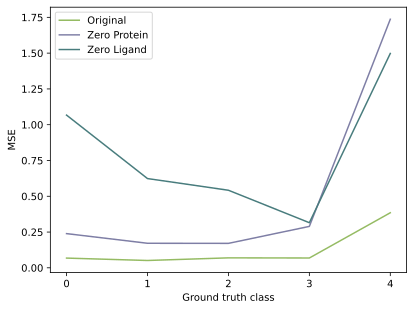

In [10]:


import matplotlib.pyplot as plt

mse_protein = []
mse_ligand = []
mse_orig = []

for cls in np.unique(gt_bin):
    idx = gt_bin == cls
    mse_orig.append(mean_squared_error(gt[idx], preds_original[idx]))
    mse_protein.append(mean_squared_error(gt[idx], preds_zero_protein[idx]))
    mse_ligand.append(mean_squared_error(gt[idx], preds_zero_ligand[idx]))

plt.plot(mse_orig, label='Original', color=DATASET_COLORS[0])
plt.plot(mse_protein, label='Zero Protein', color=DATASET_COLORS[1])
plt.plot(mse_ligand, label='Zero Ligand', color=DATASET_COLORS[2])
plt.xticks(range(len(np.unique(gt_bin))), np.unique(gt_bin))
plt.xlabel("Ground truth class")
plt.ylabel("MSE")
plt.legend()
plt.show()

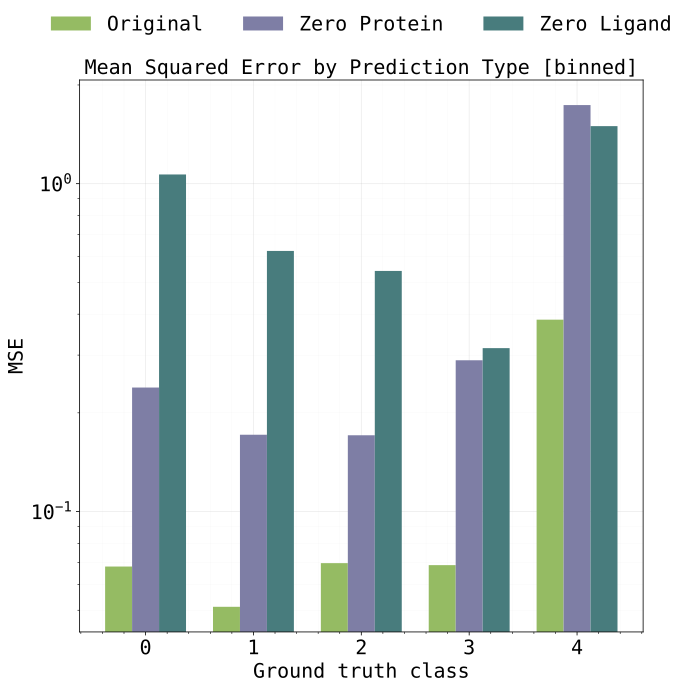

In [12]:


mse_protein = []
mse_ligand = []
mse_orig = []
class_labels = np.unique(gt_bin)

for cls in class_labels:
    idx = gt_bin == cls
    mse_orig.append(mean_squared_error(gt[idx], preds_original[idx]))
    mse_protein.append(mean_squared_error(gt[idx], preds_zero_protein[idx]))
    mse_ligand.append(mean_squared_error(gt[idx], preds_zero_ligand[idx]))

mse_orig = np.array(mse_orig)
mse_protein = np.array(mse_protein)
mse_ligand = np.array(mse_ligand)

# --- Grouped Bar Plotting ---
n_classes = len(class_labels)
bar_width = 0.25         #Define the width of each bar
x = np.arange(n_classes) # The central x-locations for the class groups

fig, ax = get_styled_figure_ax(aspect='none',grid=True)

# Plot the bars, adjusting the x-position for each set
rects1 = ax.bar(x - bar_width, mse_orig, bar_width, 
                label='Original', color=DATASET_COLORS[0])
rects2 = ax.bar(x, mse_protein, bar_width, 
                label='Zero Protein', color=DATASET_COLORS[1])
rects3 = ax.bar(x + bar_width, mse_ligand, bar_width, 
                label='Zero Ligand', color=DATASET_COLORS[2])

ax.set_yscale('log')
ax.set_xlabel("Ground truth class")
ax.set_ylabel("MSE")
ax.set_title("Mean Squared Error by Prediction Type [binned]")
style_legend(ax, ncol=3, bbox_to_anchor=(0.5, 1.15))
plt.tight_layout()
plt.savefig('results/latent_space/mse_by_zeroed-out-predidction-type.svg')
plt.show()
plt.close();

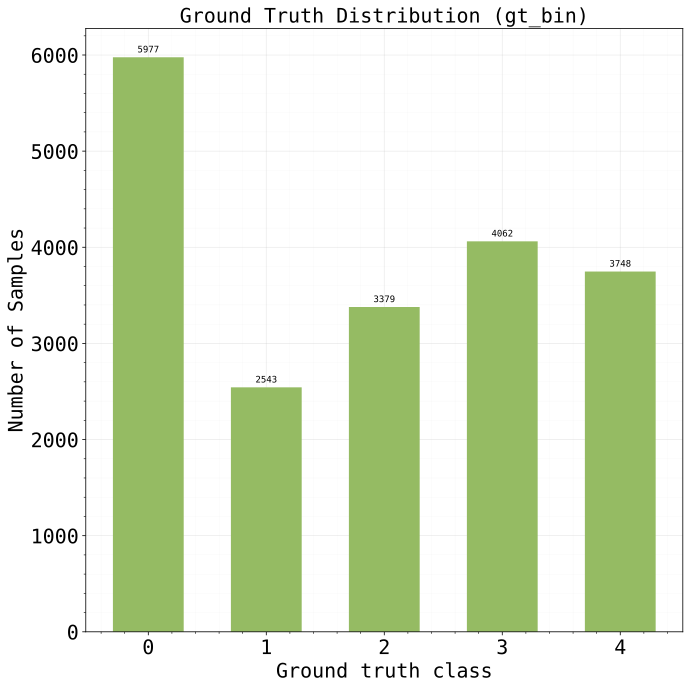

In [12]:
# --- Calculate Distribution ---
unique_classes, class_counts = np.unique(gt_bin, return_counts=True)

# --- Plotting ---
fig, ax = get_styled_figure_ax(aspect='none', grid=True)

# Create the bar chart
rects = ax.bar(unique_classes, class_counts, 
               width=0.6, 
               color=DATASET_COLORS[0], 
               label='Sample Count')

# formatting
ax.set_xlabel("Ground truth class")
ax.set_ylabel("Number of Samples")
ax.set_title("Ground Truth Distribution (gt_bin)")

# Critical: Add text annotations to see exact numbers
# This helps identify if a high MSE is caused by n=1 or n=2 samples
ax.bar_label(rects, padding=3, fmt='%d', fontsize=9)

# Optional: Log scale if you have a massive imbalance (e.g., 10k vs 10 samples)
# ax.set_yscale('log') 

plt.tight_layout()
plt.savefig('results/latent_space/gt_class_distribution.svg')
plt.show()
plt.close()

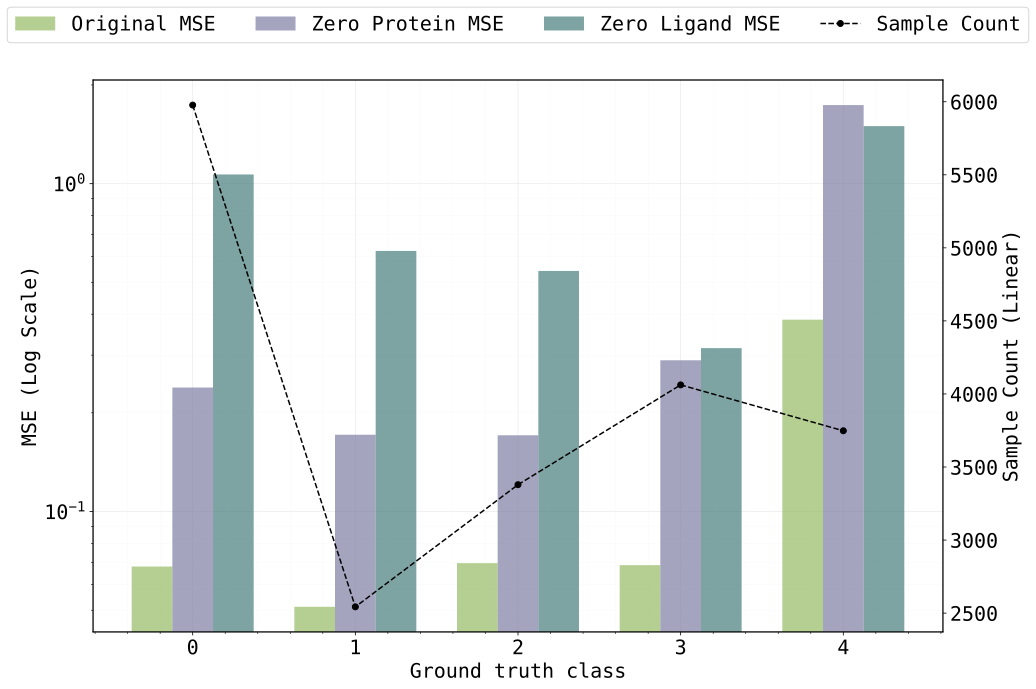

In [13]:
fig, ax1 = get_styled_figure_ax(figsize=(15, 10),aspect='none', grid=True)

# --- Plot MSE (Left Axis) ---
rects1 = ax1.bar(x - bar_width, mse_orig, bar_width, 
                 label='Original MSE', color=DATASET_COLORS[0], alpha=0.7)
rects2 = ax1.bar(x, mse_protein, bar_width, 
                 label='Zero Protein MSE', color=DATASET_COLORS[1], alpha=0.7)
rects3 = ax1.bar(x + bar_width, mse_ligand, bar_width, 
                 label='Zero Ligand MSE', color=DATASET_COLORS[2], alpha=0.7)

ax1.set_yscale('log')
ax1.set_xlabel("Ground truth class")
ax1.set_ylabel("MSE (Log Scale)")
#ax1.set_title("MSE vs Class Distribution")

# --- Plot Distribution (Right Axis) ---
# Calculate counts
values, counts = np.unique(gt_bin, return_counts=True)

# Create a twin axis sharing the x-axis
ax2 = ax1.twinx() 
ax2.set_ylabel("Sample Count (Linear)", color='black')

# Plot a step line or scatter to distinguish from the bars
ax2.plot(values, counts, color='black', marker='o', linestyle='--', linewidth=1.5, label='Sample Count')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

plt.tight_layout()
plt.savefig('results/latent_space/mse_by_zeroed-out-predidction-type_with_sample-count.svg')
plt.show()
plt.close()

# Zero out embeddings based on feature importance

In [14]:
from xai.interaction_explainer import InteractionExplainer

print("Calculating feature importances...")
interaction_explainer = InteractionExplainer(model_trained, device=device)

protein_attributions_acc = np.zeros(96)
ligand_attributions_acc = np.zeros(96)
num_samples = len(indices)

for idx in tqdm(indices, desc="Calculating attributions"):
    smi, seq = data_raw.iloc[idx,:][['compound_iso_smiles', 'target_sequence']]
    data, _ = dataset.transform_unique(smi, seq)
    data = data.to(device)
    
    # We need to handle potential errors in gradient calculation for some samples
    try:
        feature_result = interaction_explainer.gradient_interaction_map(data)
        protein_attributions_acc += feature_result['protein_attributions']
        ligand_attributions_acc += feature_result['ligand_attributions']
    except Exception as e:
        print(f"Skipping sample {idx} due to error: {e}")
        num_samples -= 1

avg_protein_attributions = protein_attributions_acc / num_samples
avg_ligand_attributions = ligand_attributions_acc / num_samples

print("Average feature importances calculated.")

Calculating feature importances...


Calculating attributions:   0%|                                                                                                                                                         | 0/19709 [00:00<?, ?it/s]/home/alex/dev/projects/dl_imt4392/dl_project/MGraphDTA/regression/preprocessing.py:140: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  target=torch.LongTensor([target]),
Calculating attributions: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19709/19709 [17:24<00:00, 18.87it/s]

Average feature importances calculated.


In [15]:

folder = 'results/latent_space'
filename = f'avg_protein_attributions_kiba_{max_sample_train}_2578.npy'
np.save(os.path.join(folder, filename), avg_protein_attributions)
filename = f'avg_ligand_attributions_kiba_{max_sample_train}_2578.npy'
np.save(os.path.join(folder, filename), avg_ligand_attributions)

In [8]:

folder = 'results/latent_space'
filename = f'avg_protein_attributions_kiba_{max_sample_train}_2578.npy'
avg_protein_attributions = np.load(os.path.join(folder, filename))
filename = f'avg_ligand_attributions_kiba_{max_sample_train}_2578.npy'
avg_ligand_attributions = np.load(os.path.join(folder, filename))

In [9]:

# Identify least and most important dimensions
num_dims_to_zero = 48 # Corresponds to half of the embedding size

# Sort by absolute value of attribution to find least/most important
least_important_protein_dims = np.argsort(np.abs(avg_protein_attributions))[:num_dims_to_zero]
least_important_ligand_dims = np.argsort(np.abs(avg_ligand_attributions))[:num_dims_to_zero]

most_important_protein_dims = np.argsort(np.abs(avg_protein_attributions))[-num_dims_to_zero:]
most_important_ligand_dims = np.argsort(np.abs(avg_ligand_attributions))[-num_dims_to_zero:]

print(f"Top 5 least important protein dims: {least_important_protein_dims[:5]}")
print(f"Top 5 most important protein dims: {most_important_protein_dims[-5:]}")
print(f"Top 5 least important ligand dims: {least_important_ligand_dims[:5]}")
print(f"Top 5 most important ligand dims: {most_important_ligand_dims[-5:]}")

Top 5 least important protein dims: [53 93 36 62 91]
Top 5 most important protein dims: [61 76 72 67 37]
Top 5 least important ligand dims: [68 42 50 85 45]
Top 5 most important ligand dims: [35 31 23 11 43]


In [17]:

# Generate predictions with important/unimportant dimensions zeroed out
preds_zero_protein_least_imp = []
preds_zero_ligand_least_imp = []
preds_zero_protein_most_imp = []
preds_zero_ligand_most_imp = []

for idx in tqdm(indices, desc="Generating predictions"):
    smi, seq = data_raw.iloc[idx,:][['compound_iso_smiles', 'target_sequence']]
    data, _ = dataset.transform_unique(smi, seq)
    data = data.to(device)

    with torch.no_grad():
        _, protein_emb, ligand_emb = model_trained.forward_features(data)

        # 1. Zero out LEAST important protein dimensions
        protein_emb_least_imp = protein_emb.clone()
        protein_emb_least_imp[:, least_important_protein_dims] = 0
        emb_zero_prot_least_imp = torch.hstack((protein_emb_least_imp, ligand_emb))
        preds_zero_protein_least_imp.append(model_trained.classifier(emb_zero_prot_least_imp).item())
        
        # 2. Zero out LEAST important ligand dimensions
        ligand_emb_least_imp = ligand_emb.clone()
        ligand_emb_least_imp[:, least_important_ligand_dims] = 0
        emb_zero_lig_least_imp = torch.hstack((protein_emb, ligand_emb_least_imp))
        preds_zero_ligand_least_imp.append(model_trained.classifier(emb_zero_lig_least_imp).item())

        # 3. Zero out MOST important protein dimensions
        protein_emb_most_imp = protein_emb.clone()
        protein_emb_most_imp[:, most_important_protein_dims] = 0
        emb_zero_prot_most_imp = torch.hstack((protein_emb_most_imp, ligand_emb))
        preds_zero_protein_most_imp.append(model_trained.classifier(emb_zero_prot_most_imp).item())

        # 4. Zero out MOST important ligand dimensions
        ligand_emb_most_imp = ligand_emb.clone()
        ligand_emb_most_imp[:, most_important_ligand_dims] = 0
        emb_zero_lig_most_imp = torch.hstack((protein_emb, ligand_emb_most_imp))
        preds_zero_ligand_most_imp.append(model_trained.classifier(emb_zero_lig_most_imp).item())

preds_zero_protein_least_imp = np.array(preds_zero_protein_least_imp)
preds_zero_ligand_least_imp = np.array(preds_zero_ligand_least_imp)
preds_zero_protein_most_imp = np.array(preds_zero_protein_most_imp)
preds_zero_ligand_most_imp = np.array(preds_zero_ligand_most_imp)

print("Predictions with importance-based zeroing generated.")

Generating predictions: 100%|████████████████████████████████████| 19709/19709 [07:11<00:00, 45.65it/s]

Predictions with importance-based zeroing generated.


In [18]:

folder = 'results/latent_space'
for _file, _arr in [
    ('preds_zero_protein_least_imp', preds_zero_protein_least_imp),
    ('preds_zero_ligand_least_imp',preds_zero_ligand_least_imp),
    ('preds_zero_protein_most_imp',preds_zero_protein_most_imp),
    ('preds_zero_ligand_most_imp',preds_zero_ligand_most_imp)
     ]:
    filename = f'{_file}_kiba_{max_sample_train}_2578.npy'
    np.save(os.path.join(folder, filename), _arr)

In [10]:
folder = 'results/latent_space'
file_base_names = [
    'preds_zero_protein_least_imp',
    'preds_zero_ligand_least_imp',
    'preds_zero_protein_most_imp',
    'preds_zero_ligand_most_imp'
]
loaded_arrays = {}
for _file in file_base_names:
    filename = f'{_file}_kiba_{max_sample_train}_2578.npy'
    filepath = os.path.join(folder, filename)
    loaded_arrays[_file] = np.load(filepath)

preds_zero_protein_least_imp = loaded_arrays.get('preds_zero_protein_least_imp')
preds_zero_ligand_least_imp = loaded_arrays.get('preds_zero_ligand_least_imp')
preds_zero_protein_most_imp = loaded_arrays.get('preds_zero_protein_most_imp')
preds_zero_ligand_most_imp = loaded_arrays.get('preds_zero_ligand_most_imp')

In [13]:

# Calculate MSE for the new prediction sets
mse_protein_least_imp = []
mse_ligand_least_imp = []
mse_protein_most_imp = []
mse_ligand_most_imp = []

for cls in class_labels:
    idx = gt_bin == cls
    mse_protein_least_imp.append(mean_squared_error(gt[idx], preds_zero_protein_least_imp[idx]))
    mse_ligand_least_imp.append(mean_squared_error(gt[idx], preds_zero_ligand_least_imp[idx]))
    mse_protein_most_imp.append(mean_squared_error(gt[idx], preds_zero_protein_most_imp[idx]))
    mse_ligand_most_imp.append(mean_squared_error(gt[idx], preds_zero_ligand_most_imp[idx]))

mse_protein_least_imp = np.array(mse_protein_least_imp)
mse_ligand_least_imp = np.array(mse_ligand_least_imp)
mse_protein_most_imp = np.array(mse_protein_most_imp)
mse_ligand_most_imp = np.array(mse_ligand_most_imp)

print("MSE calculation complete.")

MSE calculation complete.


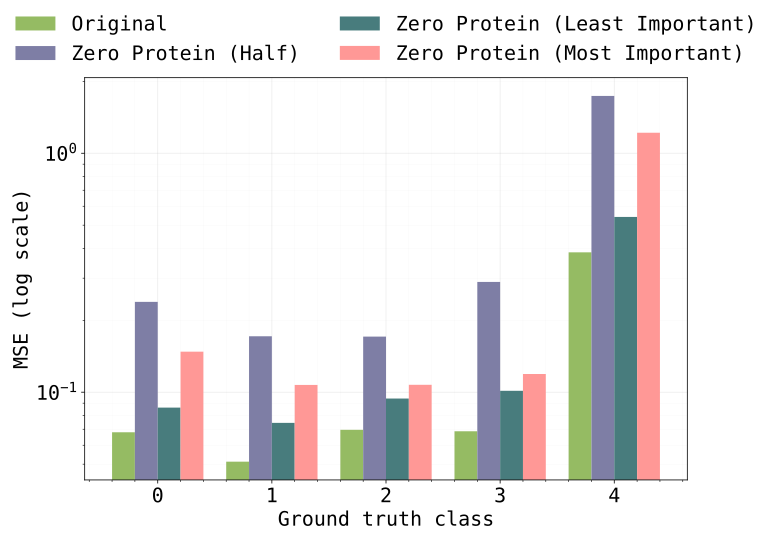

In [21]:

# Plotting the results - PROTEIN focused
n_classes = len(class_labels)
bar_width = 0.2
x = np.arange(n_classes)

fig, ax = get_styled_figure_ax(figsize=(11, 8),aspect='none', grid=True)

ax.bar(x - 1.5 * bar_width, mse_orig, bar_width, label='Original', color=DATASET_COLORS[0])
ax.bar(x - 0.5 * bar_width, mse_protein, bar_width, label='Zero Protein (Half)', color=DATASET_COLORS[1])
ax.bar(x + 0.5 * bar_width, mse_protein_least_imp, bar_width, label='Zero Protein (Least Important)', color=DATASET_COLORS[2])
ax.bar(x + 1.5 * bar_width, mse_protein_most_imp, bar_width, label='Zero Protein (Most Important)', color='#FF9896')

ax.set_yscale('log')
ax.set_xlabel("Ground truth class")
ax.set_ylabel("MSE (log scale)")
#ax.set_title("MSE Comparison for Zeroed-Out Protein Embeddings")
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
style_legend(ax, ncol=2, bbox_to_anchor=(0.5, 1.2))
plt.tight_layout()
plt.savefig('results/latent_space/mse_by_zeroed-out_protein_importance.svg')
plt.show()
plt.close();

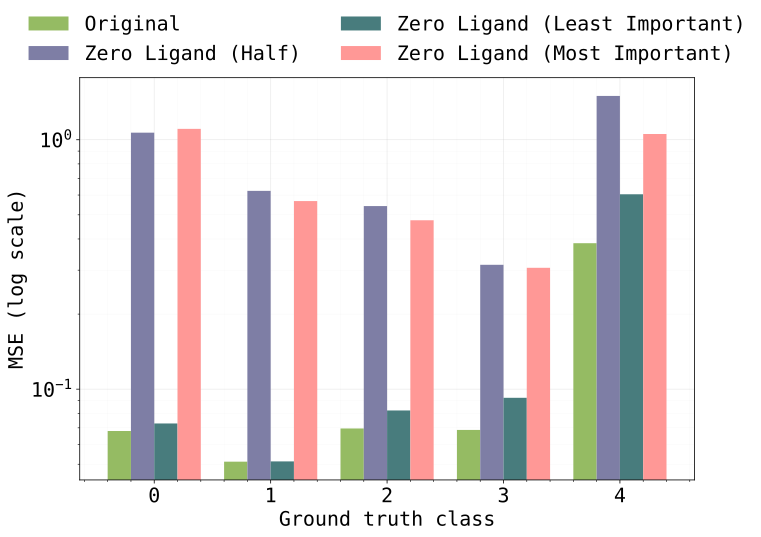

In [22]:

# Plotting the results - LIGAND focused
fig, ax = get_styled_figure_ax(figsize=(11, 8),aspect='none', grid=True)

ax.bar(x - 1.5 * bar_width, mse_orig, bar_width, label='Original', color=DATASET_COLORS[0])
ax.bar(x - 0.5 * bar_width, mse_ligand, bar_width, label='Zero Ligand (Half)', color=DATASET_COLORS[1])
ax.bar(x + 0.5 * bar_width, mse_ligand_least_imp, bar_width, label='Zero Ligand (Least Important)', color=DATASET_COLORS[2])#color='#AEC7E8')
ax.bar(x + 1.5 * bar_width, mse_ligand_most_imp, bar_width, label='Zero Ligand (Most Important)', color='#FF9896')

ax.set_yscale('log')
ax.set_xlabel("Ground truth class")
ax.set_ylabel("MSE (log scale)")
#ax.set_title("MSE Comparison for Zeroed-Out Ligand Embeddings")
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
style_legend(ax, ncol=2, bbox_to_anchor=(0.5, 1.2))
plt.tight_layout()
plt.savefig('results/latent_space/mse_by_zeroed-out_ligand_importance.svg')
plt.show()
plt.close();

In [23]:
data = {
    "Class": class_labels,
    "Original": mse_orig,
    # Protein Data
    "Prot (Half)": mse_protein,
    "Prot (Least)": mse_protein_least_imp,
    "Prot (Most)": mse_protein_most_imp,
    # Ligand Data
    "Lig (Half)": mse_ligand,
    "Lig (Least)": mse_ligand_least_imp,
    "Lig (Most)": mse_ligand_most_imp,
}

# 2. Create DataFrame
df_results = pd.DataFrame(data)

# 3. Print as LaTeX
# float_format="%.4f" ensures 4 decimal places. 
latex_code = df_results.to_latex(
    index=False, 
    float_format="%.4f", 
    caption="MSE Comparison for Zeroed-Out Protein and Ligand Embeddings",
    label="tab:mse_results",
    column_format="l" + "c" * (len(df_results.columns) - 1) # Left align text, center numbers
)

print(latex_code)

\begin{table}
\caption{MSE Comparison for Zeroed-Out Protein and Ligand Embeddings}
\label{tab:mse_results}
\begin{tabular}{lccccccc}
\toprule
Class & Original & Prot (Half) & Prot (Least) & Prot (Most) & Lig (Half) & Lig (Least) & Lig (Most) \\
\midrule
0 & 0.0680 & 0.2389 & 0.0862 & 0.1478 & 1.0670 & 0.0729 & 1.1055 \\
1 & 0.0512 & 0.1715 & 0.0744 & 0.1073 & 0.6236 & 0.0513 & 0.5677 \\
2 & 0.0696 & 0.1709 & 0.0941 & 0.1074 & 0.5419 & 0.0822 & 0.4755 \\
3 & 0.0686 & 0.2894 & 0.1014 & 0.1192 & 0.3151 & 0.0923 & 0.3065 \\
4 & 0.3848 & 1.7368 & 0.5414 & 1.2181 & 1.4978 & 0.6043 & 1.0542 \\
\bottomrule
\end{tabular}
\end{table}



In [24]:
import numpy as np

print(r"\begin{table}[h]")
print(r"\centering")
print(r"\caption{MSE Results: Bold indicates lowest error within specific perturbation group}")
# l = left align (text), c = center align (numbers)
# The pipes (|) visually separate Original vs Protein vs Ligand groups
print(r"\begin{tabular}{l|c|ccc|ccc}") 
print(r"\hline")
print(r"\textbf{Class} & \textbf{Original} & \textbf{P (Half)} & \textbf{P (Least)} & \textbf{P (Most)} & \textbf{L (Half)} & \textbf{L (Least)} & \textbf{L (Most)} \\")
print(r"\hline")

for i, label in enumerate(class_labels):
    # 1. Get the specific groups of values for this class
    p_vals = [mse_protein[i], mse_protein_least_imp[i], mse_protein_most_imp[i]]
    l_vals = [mse_ligand[i], mse_ligand_least_imp[i], mse_ligand_most_imp[i]]
    
    # 2. Find the minimum (best) score in each group
    best_p = min(p_vals)
    best_l = min(l_vals)
    
    # 3. Helper to format: returns string, wraps in \textbf if it matches the best
    def fmt(val, best_in_group):
        if val == best_in_group:
            return f"\\textbf{{{val:.4f}}}"
        return f"{val:.4f}"

    # 4. Construct the row string
    # Original is printed plain as a baseline reference
    row = (f"{label} & {mse_orig[i]:.4f} & "
           f"{fmt(p_vals[0], best_p)} & {fmt(p_vals[1], best_p)} & {fmt(p_vals[2], best_p)} & "
           f"{fmt(l_vals[0], best_l)} & {fmt(l_vals[1], best_l)} & {fmt(l_vals[2], best_l)} \\\\")
    
    print(row)

print(r"\hline")
print(r"\end{tabular}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{MSE Results: Bold indicates lowest error within specific perturbation group}
\begin{tabular}{l|c|ccc|ccc}
\hline
\textbf{Class} & \textbf{Original} & \textbf{P (Half)} & \textbf{P (Least)} & \textbf{P (Most)} & \textbf{L (Half)} & \textbf{L (Least)} & \textbf{L (Most)} \\
\hline
0 & 0.0680 & 0.2389 & \textbf{0.0862} & 0.1478 & 1.0670 & \textbf{0.0729} & 1.1055 \\
1 & 0.0512 & 0.1715 & \textbf{0.0744} & 0.1073 & 0.6236 & \textbf{0.0513} & 0.5677 \\
2 & 0.0696 & 0.1709 & \textbf{0.0941} & 0.1074 & 0.5419 & \textbf{0.0822} & 0.4755 \\
3 & 0.0686 & 0.2894 & \textbf{0.1014} & 0.1192 & 0.3151 & \textbf{0.0923} & 0.3065 \\
4 & 0.3848 & 1.7368 & \textbf{0.5414} & 1.2181 & 1.4978 & \textbf{0.6043} & 1.0542 \\
\hline
\end{tabular}
\end{table}
